In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import numpy as np

In [55]:
# DATA
# data_supereasy = pd.read_parquet("data/super_easy/track2_data.parquet")
# print("supereasy data shape:", data_supereasy.shape)       
# print(data_supereasy.index.name)

In [56]:
# data_easy = pd.read_parquet("data/easy/track2_data.parquet")
# data_med = pd.read_parquet("data/medium/track2_data.parquet")
data_hard = pd.read_parquet("data/hard/track2_data.parquet")

In [57]:
data = data_hard

In [58]:
# sample = data_supereasy.loc[1.0]  
# channel_42 = data_supereasy[42]
print(data.head())

channel      0         1         2         3         4         5         6     \
time_s                                                                          
0.000   -0.071995 -0.106179 -0.064442 -0.038366  0.058057 -0.074282 -0.086457   
0.002    0.004334  0.066133 -0.030231 -0.054324 -0.186476  0.007822 -0.010475   
0.004   -0.097310  0.121775 -0.036597 -0.014467 -0.043621 -0.074648 -0.059145   
0.006    0.012629  0.009373 -0.031318  0.118211 -0.057364  0.002319  0.111917   
0.008    0.040004  0.078136  0.139210  0.002493  0.086711  0.069336 -0.046121   

channel      7         8         9     ...      1014      1015      1016  \
time_s                                 ...                                 
0.000   -0.039287 -0.035095  0.043434  ... -0.315128 -0.176812 -0.015588   
0.002   -0.095239 -0.020320 -0.086309  ... -0.202685 -0.156860 -0.032755   
0.004    0.142750  0.103352 -0.053901  ... -0.213941 -0.122974  0.044855   
0.006    0.064307  0.062721  0.025918  ...  0.657698

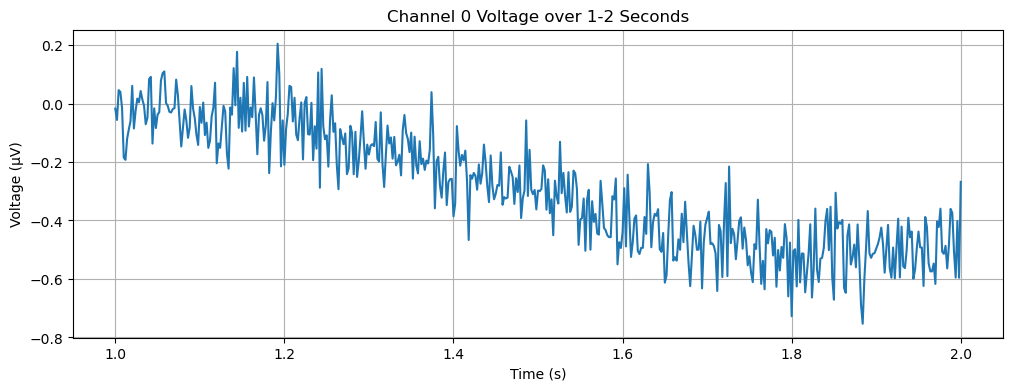

In [59]:
# EDA
channel_0 = data.loc[1:2, 0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0.index, channel_0.values)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

In [60]:
# BANDPASS FILTERING
def bandpass_filter(data, lowcut, highcut, fs=500, order=4):
    """Apply bandpass filter to extract frequency band of interest."""
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfiltfilt(sos, data, axis=0)

# filtered_theta = bandpass_filter(data, lowcut=4, highcut=12, fs=500)
# filtered_beta = bandpass_filter(data, lowcut=12, highcut=30, fs=500)
# filtered_lowgamma= bandpass_filter(data, lowcut=30, highcut=70, fs=500)
filtered_highgamma = bandpass_filter(data, lowcut=70, highcut=150, fs=500)

print("Filtered data shape:", filtered_highgamma.shape)

Filtered data shape: (150000, 1024)


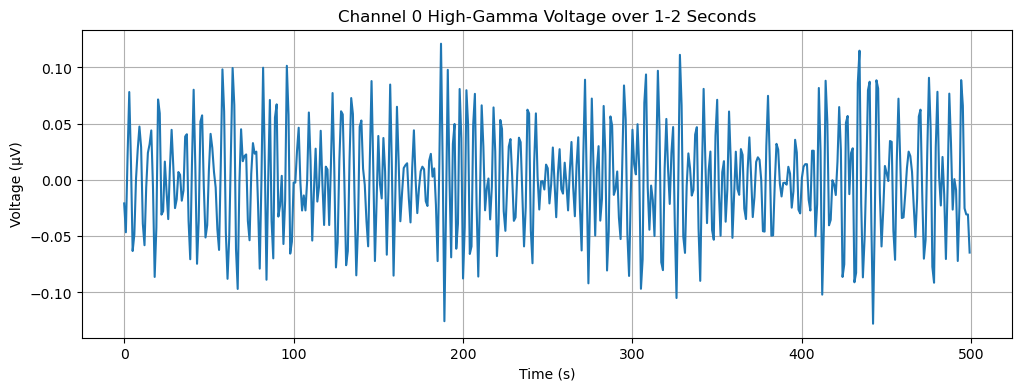

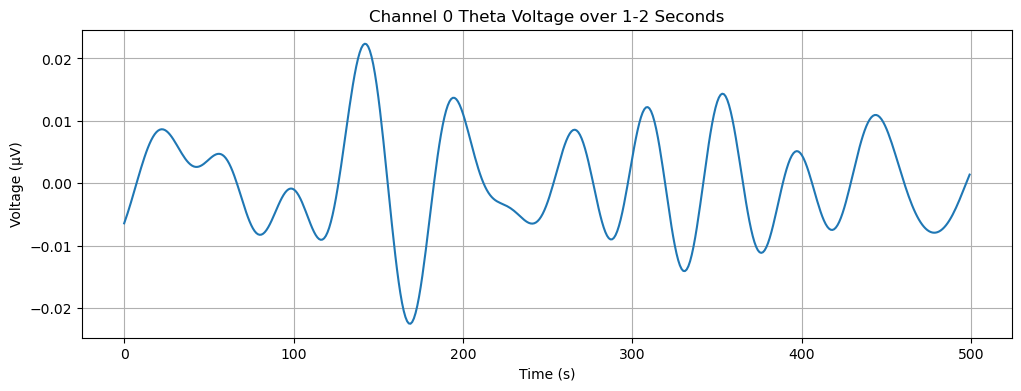

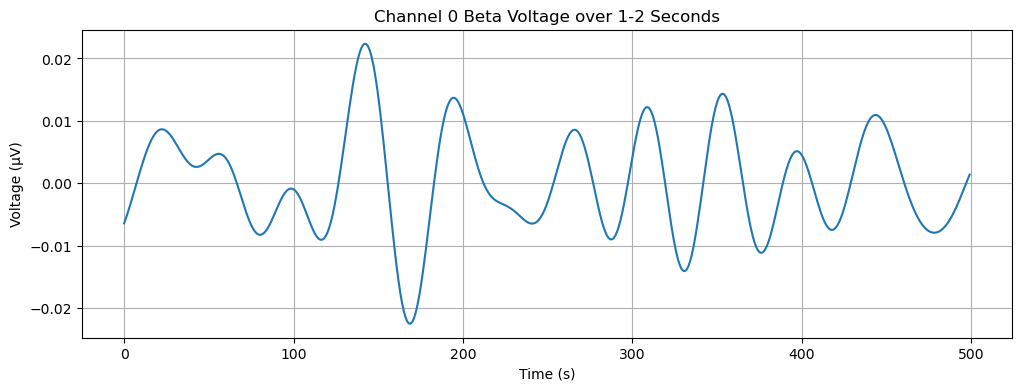

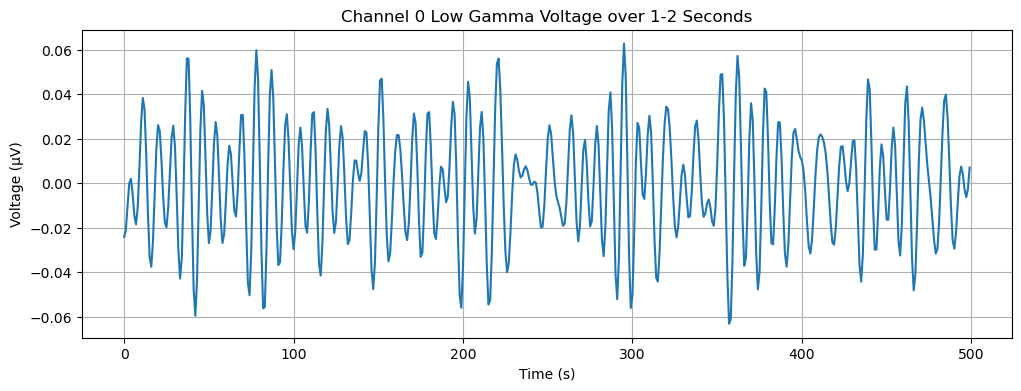

In [61]:
channel_0_highgamma= filtered_highgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_highgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 High-Gamma Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_theta= filtered_theta[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_theta)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Theta Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_beta= filtered_beta[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_theta)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Beta Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

channel_0_lowgamma= filtered_lowgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_lowgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 Low Gamma Voltage over 1-2 Seconds')
plt.grid(True)
plt.show()

In [62]:
# POWER ESTIMATION
def compute_power(filtered_data, window_ms=100, fs=500):
    """
    Compute smoothed power envelope for multi-channel data.
    
    filtered_data: (n_samples, n_channels)
    Returns: smoothed_power of same shape
    """
    n_samples, n_channels = filtered_data.shape
    window_samples = int(window_ms * fs / 1000)
    kernel = np.ones(window_samples) / window_samples

    smoothed = np.zeros_like(filtered_data)
    
    for ch in range(n_channels):
        power = filtered_data[:, ch] ** 2
        smoothed[:, ch] = np.convolve(power, kernel, mode='same')
        
    return smoothed

power_highgamma = compute_power(filtered_highgamma)
print(power_highgamma.shape)

(150000, 1024)


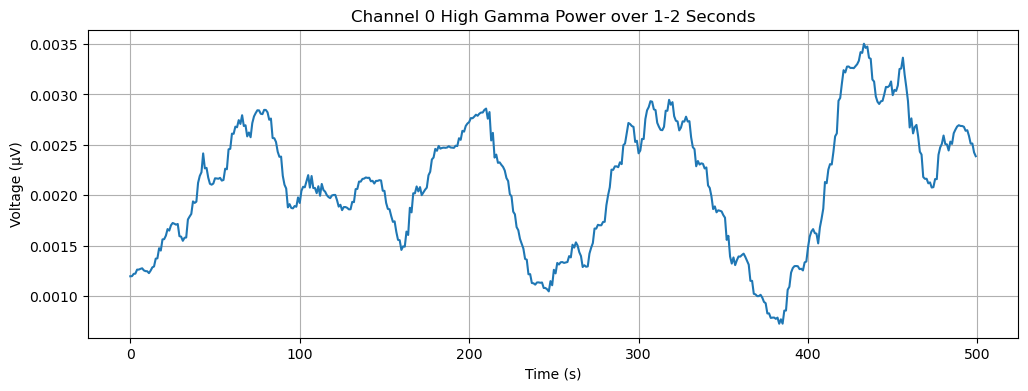

In [63]:
channel_0_power_highgamma = power_highgamma[500*1:500*2,0]
plt.figure(figsize=(12, 4))
plt.plot(channel_0_power_highgamma)  # x=index, y=values
plt.xlabel('Time (s)')  # or whatever units the index represents
plt.ylabel('Voltage (µV)')
plt.title('Channel 0 High Gamma Power over 1-2 Seconds')
plt.grid(True)
plt.show()

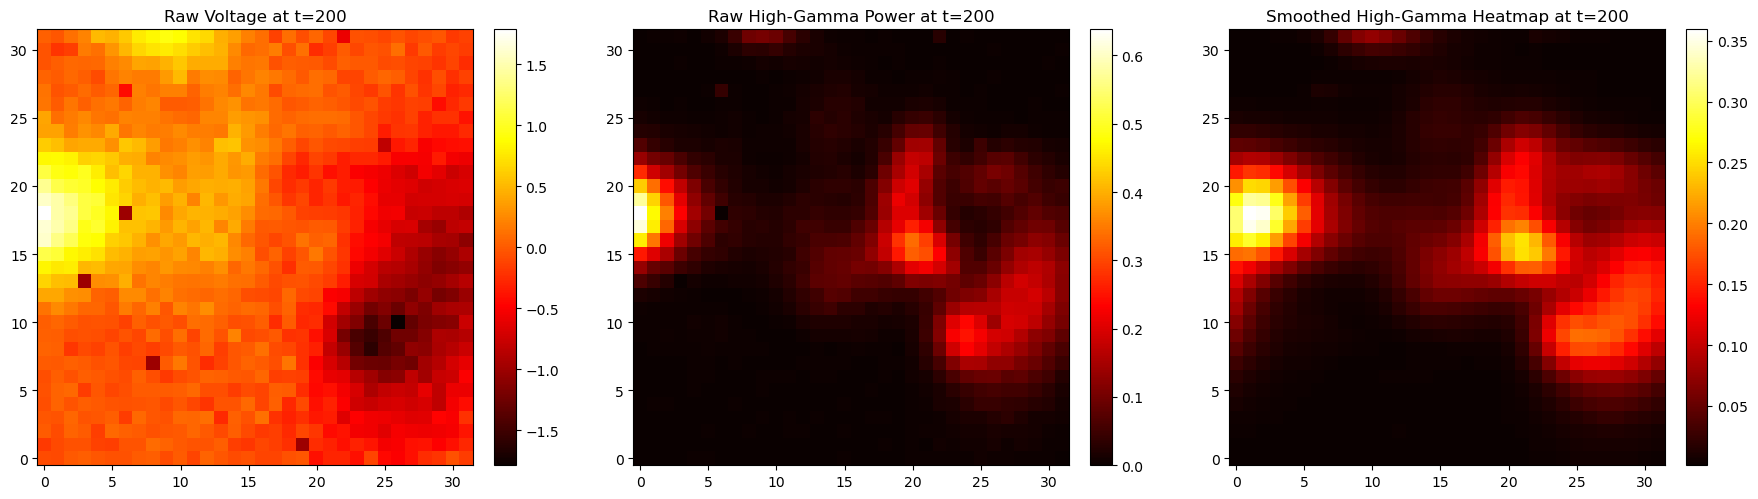

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# -----------------------------
# 1. Exponential smoothing class
# -----------------------------
class ExponentialSmoother:
    """Exponential moving average for real-time smoothing."""
    def __init__(self, alpha=0.1):
        self.alpha = alpha  # Higher = faster response, more noise
        self.state = None
    
    def update(self, new_value):
        if self.state is None:
            self.state = new_value
        else:
            self.state = self.alpha * new_value + (1 - self.alpha) * self.state
        return self.state

# -----------------------------
# 2. Spatial smoothing
# -----------------------------
def spatial_smooth(grid_data, sigma=1.5):
    """Apply Gaussian smoothing to 32x32 grid."""
    return gaussian_filter(grid_data.reshape(32, 32), sigma=sigma)

# -----------------------------
# 3. Pick one time point and display 3 plots
# -----------------------------
t = 200  # sample index

channel_raw = np.array(data.iloc[t, :])  # shape (1024,)
raw_grid = channel_raw.reshape(32, 32)

channel_power = power_highgamma[t, :]  # raw power, shape (1024,)
raw_power_grid = channel_power.reshape(32, 32)

# --- Temporal smoothing per channel ---
smoother = ExponentialSmoother(alpha=0.4)
smoothed_power = np.zeros_like(channel_power)
for ch in range(len(channel_power)):
    smoothed_power[ch] = smoother.update(channel_power[ch])

# --- Spatial smoothing ---
smoothed_heatmap = spatial_smooth(smoothed_power, sigma=0.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Raw voltage
im0 = axs[0].imshow(raw_grid, origin='lower', cmap='hot', interpolation='nearest')
axs[0].set_title(f'Raw Voltage at t={t}')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# 2. Raw high-gamma power
im1 = axs[1].imshow(raw_power_grid, origin='lower', cmap='hot', interpolation='nearest')
axs[1].set_title(f'Raw High-Gamma Power at t={t}')
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# 3. Smoothed high-gamma heatmap
im2 = axs[2].imshow(smoothed_heatmap, origin='lower', cmap='hot', interpolation='nearest')
axs[2].set_title(f'Smoothed High-Gamma Heatmap at t={t}')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


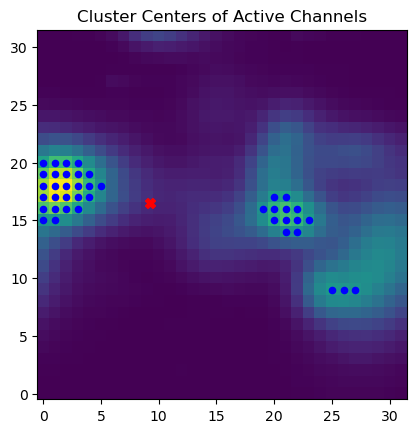

Cluster centers (y, x):
[[16.46341463  9.2195122 ]]
Direction vector (y, x): [ 0.46341463 -6.7804878 ]
Unit movement vector (y, x): [ 0.06818626 -0.99767261]


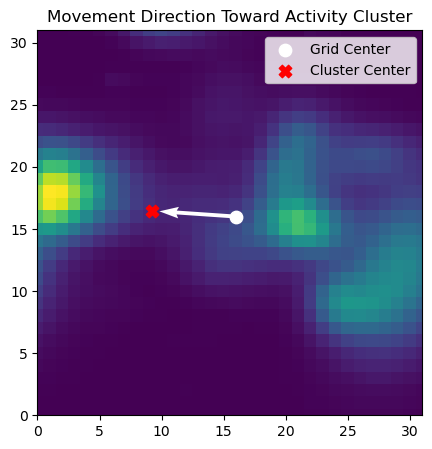

: 

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

activity = smoothed_heatmap

# Step 1: pick active points
threshold = np.percentile(activity, 96)
active_points = np.argwhere(activity > threshold)  # (y, x) coordinates

# Step 2: run K-Means
k = 1  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(active_points)
cluster_centers = kmeans.cluster_centers_

# Step 3: visualize
plt.imshow(activity, cmap='viridis', origin='lower')  # <-- add origin='lower'
plt.scatter(active_points[:, 1], active_points[:, 0], c='blue', s=20)
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c='red', s=50, marker='X')
plt.title("Cluster Centers of Active Channels")
plt.show()

print("Cluster centers (y, x):")
print(cluster_centers)

# Grid center (y, x)
grid_center = np.array([16, 16])

# Cluster center (y, x)
cluster_center = cluster_centers[0]

# Direction vector (center -> cluster)
direction = cluster_center - grid_center

# Unit vector
norm = np.linalg.norm(direction)
unit_vector = direction / norm if norm != 0 else np.array([0.0, 0.0])

print("Direction vector (y, x):", direction)
print("Unit movement vector (y, x):", unit_vector)

plt.figure(figsize=(5, 5))
plt.imshow(activity, cmap='viridis', origin='lower')

# Plot grid center
plt.scatter(16, 16, c='white', s=80, marker='o', label='Grid Center')

# Plot cluster center
plt.scatter(cluster_center[1], cluster_center[0],
            c='red', s=80, marker='X', label='Cluster Center')

# Arrow (note x,y order for plotting)
plt.quiver(
    16, 16,                    # start (x, y)
    unit_vector[1],            # dx
    unit_vector[0],            # dy
    color='white',
    scale=5,
    width=0.01
)

plt.title("Movement Direction Toward Activity Cluster")
plt.legend()
plt.xlim(0, 31)
plt.ylim(0, 31)
plt.show()

In [73]:
# # GROUND TRUTH
# gt = pd.read_parquet("data/hard/ground_truth.parquet")

# # Cursor velocity
# vx, vy = gt['vx'], gt['vy']

# # Tuned region positions (row, col in 1-32 range)
# vx_pos_row = gt['vx_pos_center_row']
# vx_pos_col = gt['vx_pos_center_col']

In [67]:
# print(vx)
# print(vx_pos_row)
# print(vx_pos_col)